# Main Analysis Pipeline

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array

Populating the interactive namespace from numpy and matplotlib


## Import the Signal Hits

In [2]:
def make_random_time(signal_file):
    random_time = OrderedDict()
    all_events = np.union1d(root2array(signal_file, "CTHHitTree", 
                                       branches="CTHHit.fEventNumber"),
                            root2array(signal_file, "CDCHitTree", 
                                       branches="CDCHit.fEventNumber"))
    for event in all_events:
        random_time[event] = np.random.uniform(-50, 50)
    return random_time

In [3]:
def import_cth_sample(cth_file, random_time, min_t=500, max_t=1170):
    # Import the hits
    hits_cth = CTHHits(cth_file, tree="CTHHitTree")
    # Smear the CTH time
    hits_cth.data[hits_cth.time_name] += np.vectorize(random_time.get)(hits_cth.get_events()[hits_cth.key_name])
    hits_cth.trim_hits(variable=hits_cth.time_name, greater_than=min_t, less_than=max_t)
    # Get the trigger time
    hits_cth.set_trigger_time()
    return np.unique(hits_cth.data[hits_cth.get_trig_hits()][hits_cth.key_name])

In [4]:
def import_cdc_sample(cdc_file, random_time, min_t=500, max_t=1620,
                      min_hits=30, min_layer=4):
    # Import the hits
    cdc_samp = CyDetHits(cdc_file, tree="CDCHitTree", selection="CDCHit.fIsSig == 1")
    # Smear the CDC time
    cdc_samp.data[cdc_samp.time_name] += np.vectorize(random_time.get)(cdc_samp.get_events()[cdc_samp.key_name])
    cdc_samp.trim_hits(variable=cdc_samp.time_name, greater_than=min_t, less_than=max_t)
    # Get the events that pass the cuts
    enough_hits = cdc_samp.min_hits_cut(min_hits)
    enough_layer = cdc_samp.min_layer_cut(min_layer)
    return np.intersect1d(enough_hits, enough_layer)

## Import The Signal Hits

In [5]:
from rootpy.tree import Tree, TreeModel, TreeChain, BoolCol, FloatCol
from rootpy.io import root_open

class ExtraBranches(TreeModel):
    GoodTrack = BoolCol()
    GoodTrig = BoolCol()
    SmearTime = FloatCol()

def copy_in_trigger_signal(in_files_name, out_file_name, tree_name, 
                           prefix, cdc_events, cth_events, random_time):
    # Convert input lists to sets first
    set_cdc_events = set(cdc_events)
    set_cth_events = set(cth_events)

    # Define the chain of input trees
    in_chain = TreeChain(name=tree_name, files=in_files_name)
    # First create a new file to save the new tree in:
    out_file = root_open(out_file_name, "r+")
    out_tree = Tree(tree_name, model=ExtraBranches.prefix(prefix))

    # This creates all the same branches in the new tree but
    # their addresses point to the same memory used by the original tree.
    out_tree.create_branches(in_chain._buffer)
    out_tree.update_buffer(in_chain._buffer)
    
    # Now loop over the original tree(s) and fill the new tree
    for entry in in_chain:
        # Add in the new values
        this_event_number = entry[prefix+"EventNumber"].value
        out_tree.__setattr__(prefix+"GoodTrack", this_event_number in set_cdc_events )
        out_tree.__setattr__(prefix+"GoodTrig",  this_event_number in set_cth_events )
        try:
            out_tree.__setattr__(prefix+"SmearTime", random_time[this_event_number])
        except:
            for key, item in entry.iteritems():
                print key, item
        # Fill, noting that most of the buffer is shared between the chain 
        # and the output tree
        out_tree.Fill()
    # Close it up
    out_tree.Write()
    out_file.Close()

In [6]:
file_base = "/home/elg112/ICEDUST_old/track_finding_standalone/"\
            "track_finding_yandex/data/"
sig_file = file_base + "oa_xx_xxx_09000001-0000_7es54i4i543a_user-TrkTree_000_signal.root"
out_file_name = file_base+"with_trig_test_both.root"
# Create an ordered dictionary of event IDs to random time smears
random_time = make_random_time(sig_file)
# Get the event indexes we will be using
good_cdc_events = import_cdc_sample(sig_file, random_time, 
                                    min_t=500, max_t=1620,
                                    min_hits=30, min_layer=4)
good_cth_events = import_cth_sample(sig_file, random_time,
                                    min_t=500, max_t=1170)
copy_in_trigger_signal(sig_file, out_file_name,  
                       "CDCHitTree", "CDCHit.f", 
                       good_cdc_events, good_cth_events,
                       random_time)
copy_in_trigger_signal(sig_file, out_file_name,  
                       "CTHHitTree", "CTHHit.f", 
                       good_cdc_events, good_cth_events,
                       random_time)

INFO:rootpy.tree.chain] 1 file remaining
INFO:rootpy.tree.chain] current file: /home/elg112/ICEDUST_old/track_finding_standalone/track_finding_yandex/data/oa_xx_xxx_09000001-0000_7es54i4i543a_user-TrkTree_000_signal.root
INFO:rootpy.tree.chain] 9874 entries per second. 72% done current tree.
INFO:rootpy.tree.chain] 9940 entries per second
INFO:rootpy.tree.chain] read 49348093 bytes in 33 transactions
INFO:rootpy.tree.chain] 1 file remaining
INFO:rootpy.tree.chain] current file: /home/elg112/ICEDUST_old/track_finding_standalone/track_finding_yandex/data/oa_xx_xxx_09000001-0000_7es54i4i543a_user-TrkTree_000_signal.root
INFO:rootpy.tree.chain] 10175 entries per second
INFO:rootpy.tree.chain] read 2719505 bytes in 24 transactions


# Check it

In [7]:
file_base = "/home/elg112/ICEDUST_old/track_finding_standalone/"\
            "track_finding_yandex/data/"
sig_file = file_base + "oa_xx_xxx_09000001-0000_7es54i4i543a_user-TrkTree_000_signal.root"
out_file_name = file_base+"with_trig_test_both.root"

In [8]:
cdc_sample = CyDetHits(out_file_name, 
                       tree="CDCHitTree",
                       selection="CDCHit.fGoodTrack == 1 && CDCHit.fGoodTrig == 1")
cth_sample = CTHHits(out_file_name, 
                     tree="CTHHitTree",
                     selection="CTHHit.fGoodTrack == 1 && CTHHit.fGoodTrig == 1")

In [9]:
print cth_sample.n_events
print cdc_sample.n_events

1485
1485


In [10]:
hits = CDCHits(cdc_sample, cth_sample)
hits.cth.set_trigger_time()

/home/elg112/development/miniconda2/envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


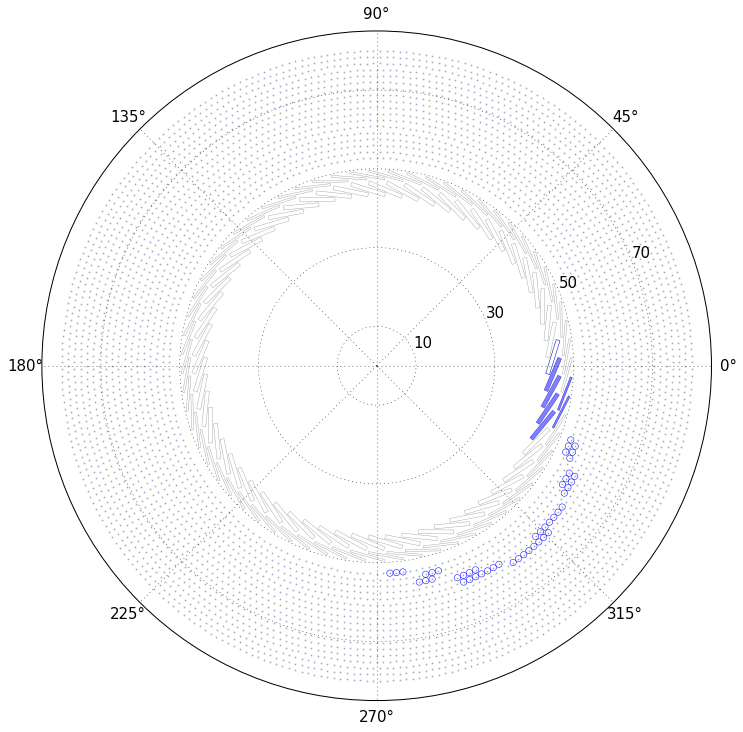

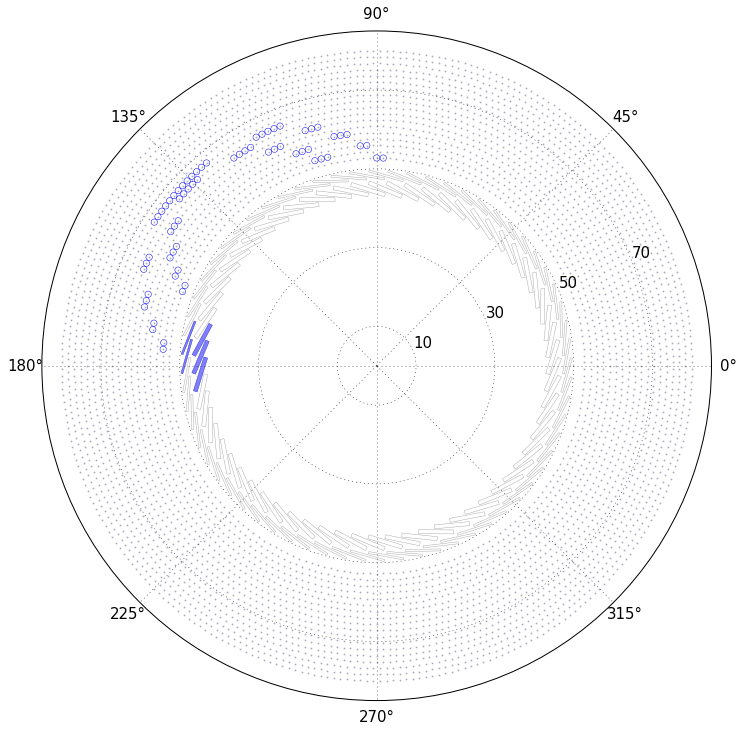

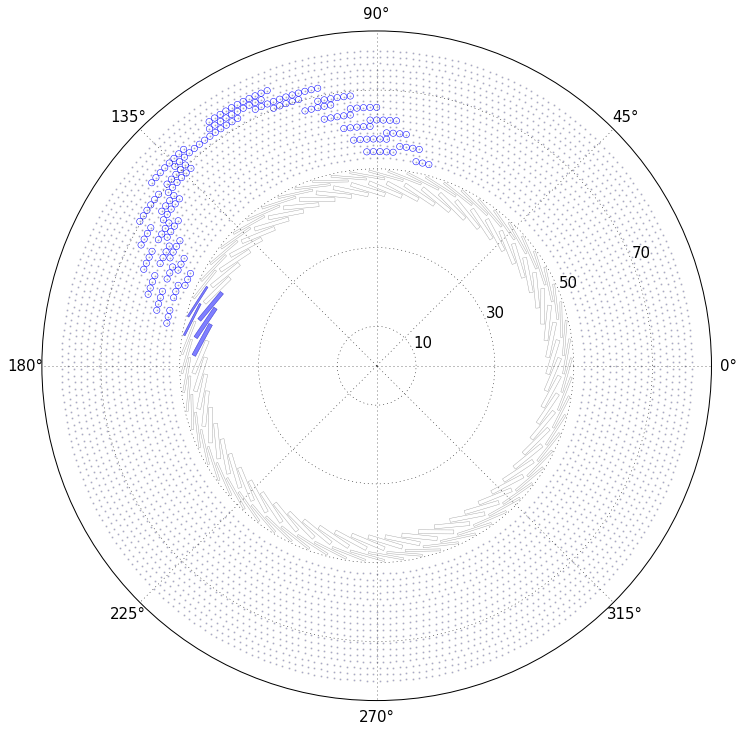

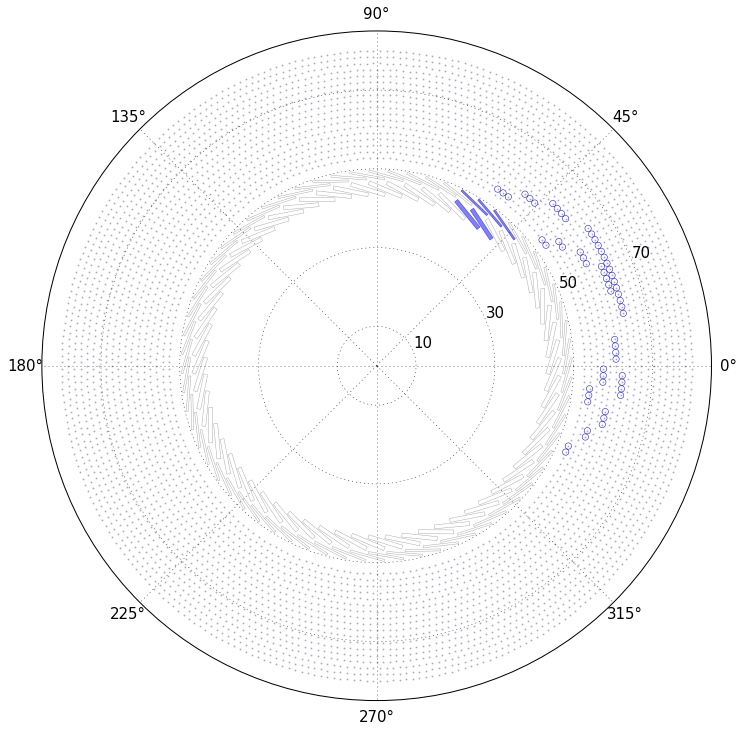

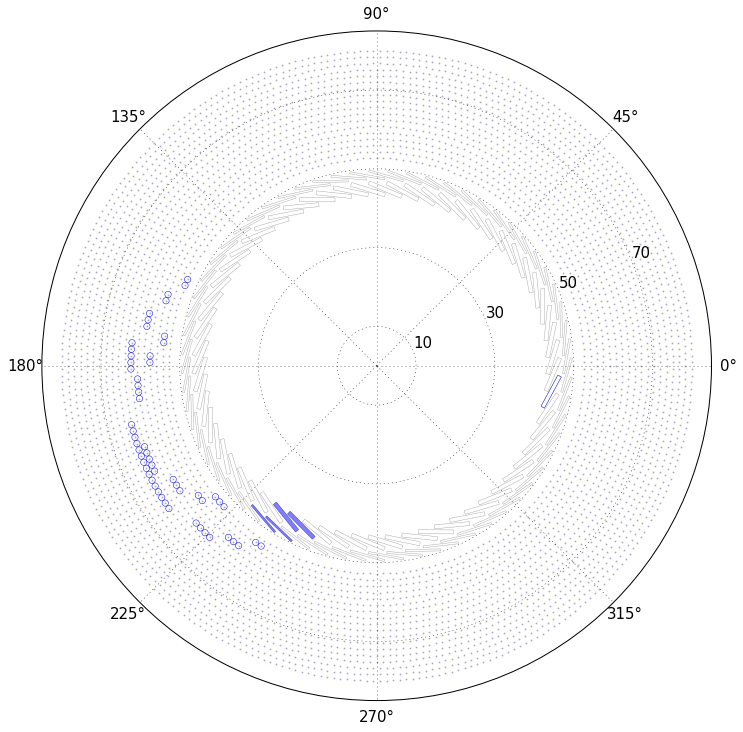

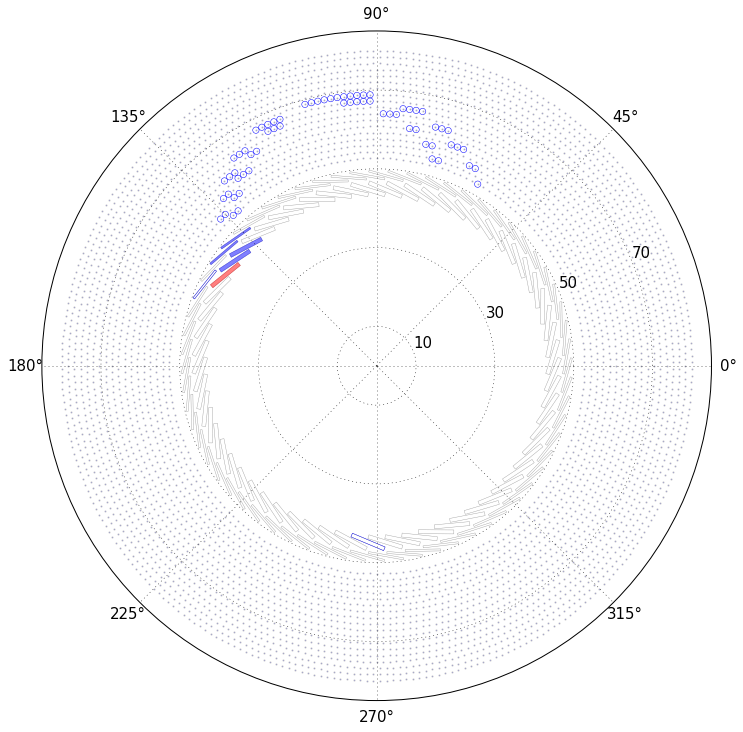

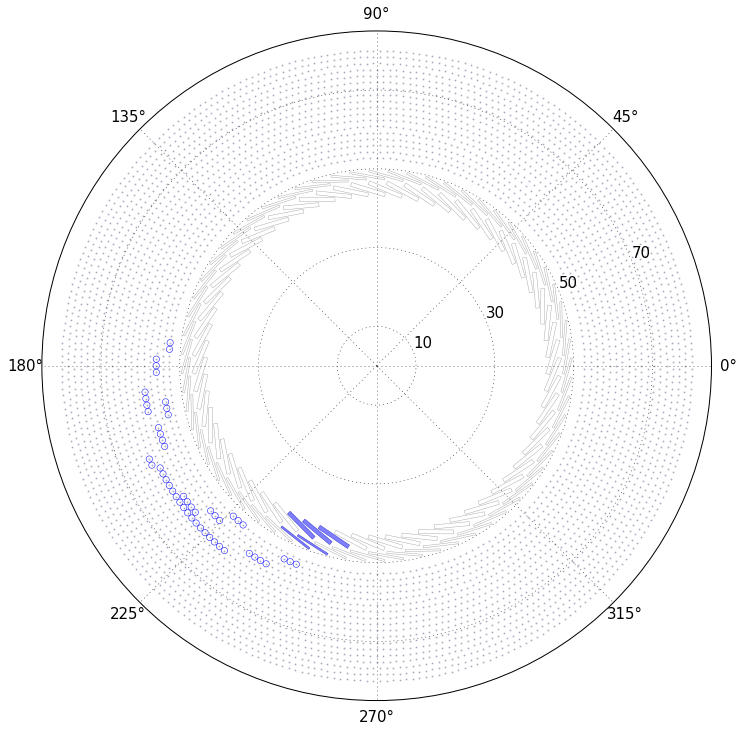

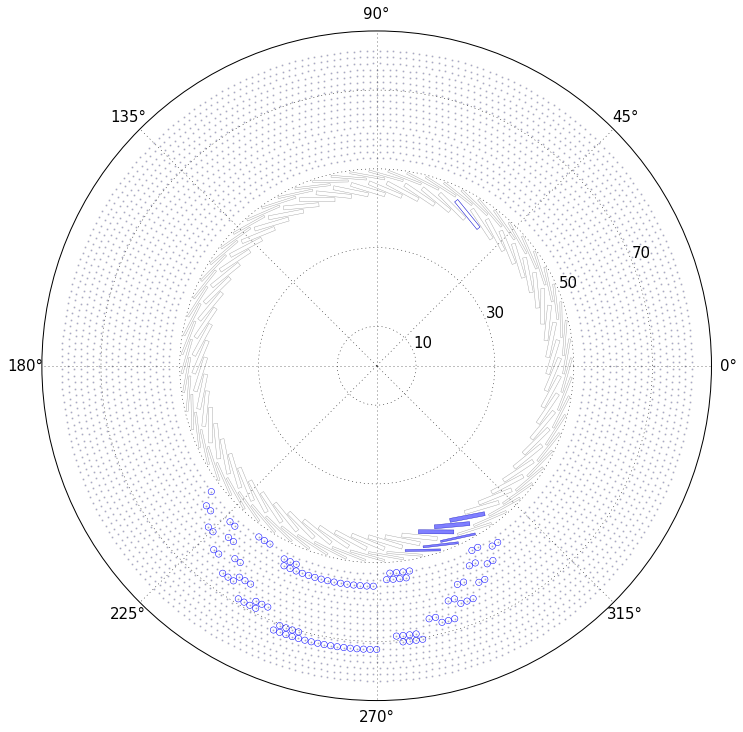

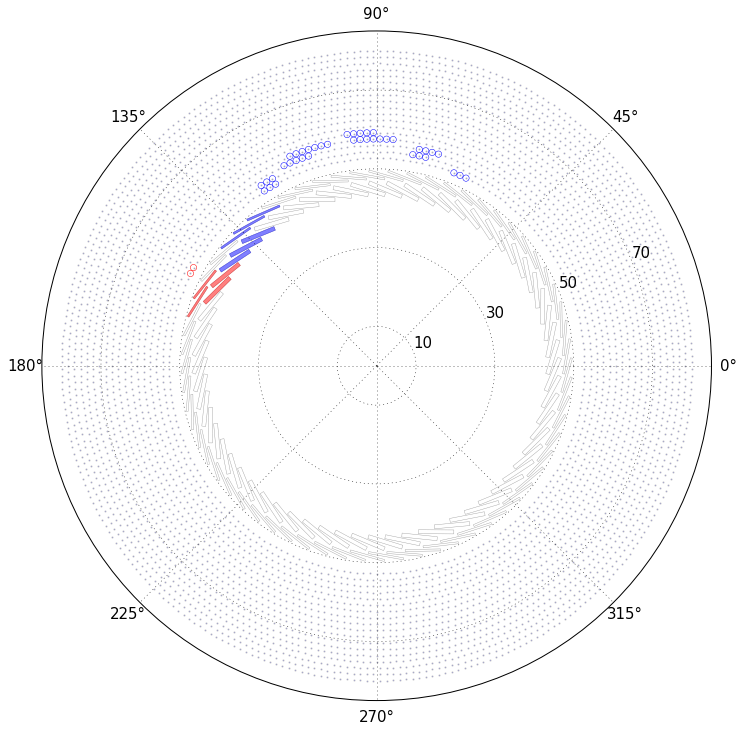

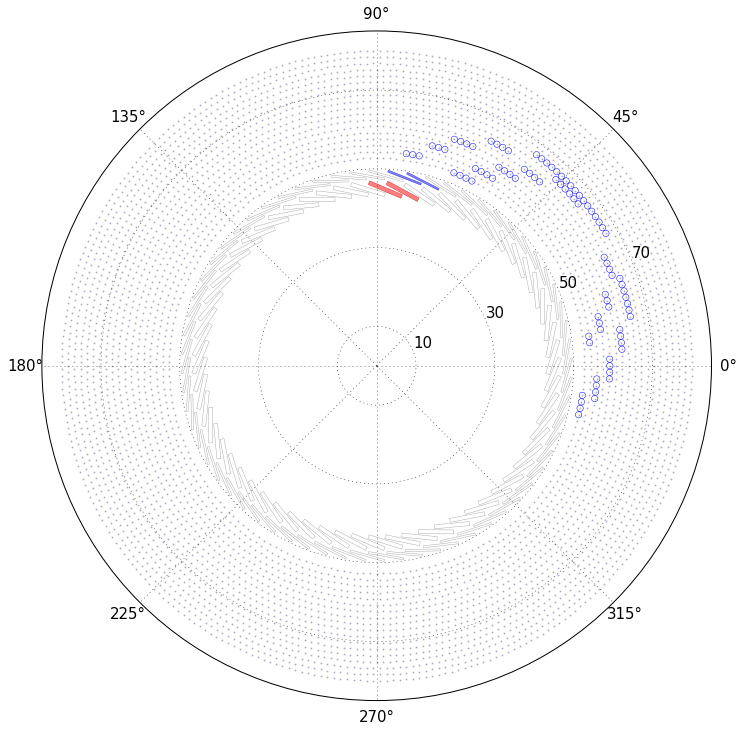

In [11]:
for evt in range(10):
    # Plot the output
    plot_output(np.zeros_like(hits.cydet.get_hit_types(evt)), hits.cydet.geom)
    # Add hit outlines
    plot_add_outlines(hits.cydet.get_hit_types(evt), hits.cydet.geom)
    # Add volume outlines
    plot_add_cth_outlines(hits.cth.geom)
    # Add the CTH vols with hits
    cth_vol_types = hits.cth.get_vol_types(evt)
    plot_add_cth(cth_vol_types, hits.cth.get_trig_vector(evt)[0], hits.cth.geom)
    cth_hits = hits.cth.get_events(evt)
    cdc_hits = hits.cydet.get_signal_hits(evt)
    #plt.scatter(cth_hits[x_pos_name], cth_hits[y_pos_name], s=1, transform=gca().transData._b)
    #plt.scatter(cdc_hits[cydet_x_pos_name], cdc_hits[cydet_y_pos_name], s=1, transform=gca().transData._b)
    plt.show()